<a href="https://colab.research.google.com/github/malhotraguy/wikipedia_project/blob/master/museumPop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install bs4
!pip install lxml
!pip install wikipedia
!pip install matplotlib
!pip install seaborn
!pip install sklearn

In [ ]:
import wikipedia
import pandas as pd 
from time import sleep
from bs4 import BeautifulSoup
import requests, lxml
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
headers = {
    'User-agent':
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)"
        "Chrome/70.0.3538.102 Safari/537.36 Edge/18.19582"
}


def get_soup_from_query(query):
    print(f"query: {query}")
    html = requests.get(f'https://www.google.com/search?q={query}&hl=en', headers=headers)
    soup = BeautifulSoup(html.text, 'html.parser')
    return soup


def get_from_knowledge_graph(query):
    soup = get_soup_from_query(query)
    for result in soup.select(".rVusze"):
        key_element = result.select_one(".w8qArf").text
        if result.select_one(".kno-fv"):
            value_element = result.select_one(".kno-fv").text.replace(": ", "")
        else:
            value_element = None
        if "population" in key_element.lower():
            return value_element


def get_google_result(city, query=None, max_retries=2):
    if query is None:
        query = f"{city} population"
    soup = get_soup_from_query(query)
    div_value = soup.find("div", {"class": "ayqGOc kno-fb-ctx KBXm4e"})
    if div_value is None:
        sleep(1)
        div_value = soup.find("div", {"class": "Z0LcW"})
    if div_value is not None:
        sleep(1)
        div_value_content = div_value.text
    else:
        sleep(1)
        div_value_content = get_from_knowledge_graph(city)
        if div_value_content is None:
            if max_retries == 0:
                return "0"
            else:
                max_retries -= 1
            sleep(2)
            return get_google_result(city=city, query=f"{city} population 2021", max_retries=max_retries)
        else:
            return div_value_content
    print(f"div_value_content: {div_value_content}")
    value_element = div_value_content.replace(u'\xa0', u' ')
    return value_element


def get_population(city):
    print(city)
    population = get_google_result(city=city)
    year_regex_search = re.search(r"\((\d{4})", population) or re.search(r"(\d{4})\)", population)
    if year_regex_search:
        year = year_regex_search.group(1)
    else:
        year = "2021"
    population = population.split("(")[0]
    population = population.strip()
    population = population.replace(",", "")
    if "million" in population.lower():
        population = population.split("million")[0]
        population = float(population) * 1000000
    else:
        for number in population.split():
            if number.isdigit():
                population = number
    print(f"Population Year: {year}")
    population = int(population)
    return population, int(year)

In [ ]:
name = 'List_of_most-visited_museums'
table_class = "wikitable sortable jquery-tablesorter"
soup = BeautifulSoup(wikipedia.page(f"{name}").html(), 'html.parser')
html_data_table = soup.find('table', {'class': "wikitable"})
# print(html_data_table)
data_list = pd.read_html(str(html_data_table))
# convert list to dataframe
data_df = pd.DataFrame(data_list[0])
if "Image" in data_df.columns:
    data_df.drop(['No.', "Image"], axis=1, inplace=True)

    data_df.rename(columns={"Country and city": "City", "Visitors annually[a]": "Visitors per year"}, inplace=True)
    data_df[["Visitors per year", "Year Reported"]] = data_df["Visitors per year"].str.split("(",
                                                                                             expand=True,
                                                                                             n=1)
    data_df[["Year Reported", "Growth"]] = data_df["Year Reported"].str.split("\)\(",
                                                                              expand=True,
                                                                              n=1)
    data_df["Visitors per year"] = data_df["Visitors per year"].apply(
        lambda no_of_visitors: get_correct_number(population=no_of_visitors))
else:
    data_df.rename(columns={"Country flag, city": "City"}, inplace=True)
    data_df["Year reported"] = data_df["Year reported"].map(lambda year: year.split("[")[0])

data_df["Population"] = data_df["City"].apply(lambda city: get_population(city=city))
data_df[["Population", "Population Reported Year"]] = pd.DataFrame(data_df["Population"].tolist(), index=data_df.index)
data_df.sort_values(by="Visitors per year", inplace=True, ignore_index=True)



div_value_content: 16.33 million (2019)
Population Year: 2019
Guangzhou
query: Guangzhou population
div_value_content: 15.31 million (Dec 31, 2019)
Population Year: 2019
Wenzhou
query: Wenzhou population
div_value_content: 9.19 million (2017)
Population Year: 2017
Suzhou
query: Suzhou population
div_value_content: 10.72 million (2018)
Population Year: 2018


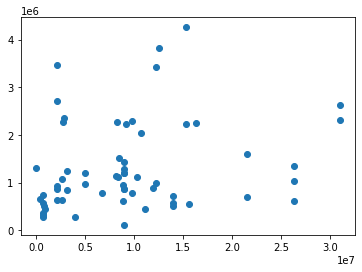

,Name,City,Visitors per year,Year reported,Population,Population Reported Year
0,Royal Museums Greenwich,London,111263,2020,8982000,2019
1,National Air and Space Museum,"Washington, D.C.",267000,2020,692683,2019
2,California Science Center,Los Angeles,271000,2020,3967000,2019
3,National Museum of American History,"Washington, D.C.",311000,2020,692683,2019
4,National Museum of African American History an...,"Washington, D.C.",368000,2020,692683,2019
...,...,...,...,...,...,...
56,Louvre,Paris,2700000,2020,2161000,2019
57,Xi'an Museum,Xi'an,3420000,2019,12283922,2021
58,Mevlana Museum,Konya,3464155,2019,2161000,2016
59,Shenzhen Museum,Shenzhen,3826000,2019,12590000,2021


In [ ]:
plt.scatter(data_df['Population'], data_df['Visitors per year'])
plt.show()
data_df

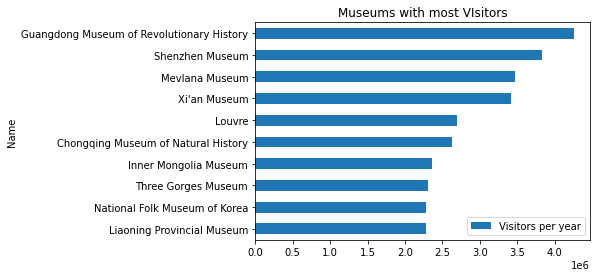

In [ ]:
data_df[-10:].plot(kind="barh",x="Name",y="Visitors per year", title="Museums with most VIsitors")


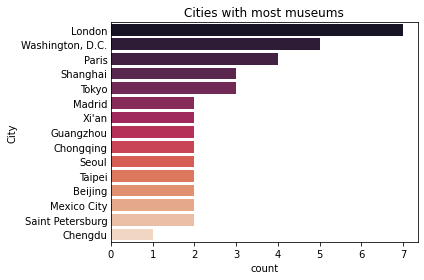

In [ ]:
ax = sns.countplot(y=data_df["City"], order=data_df["City"].value_counts().iloc[:15].index, palette='rocket')
ax.tick_params(axis='y', length=0)
ax.set_title('Cities with most museums')
plt.tight_layout()
plt.show()

In [ ]:
# 'Cities with most Visitors per year'
top_visitors_cities_df = data_df.groupby(["City"]).sum()["Visitors per year"].sort_values(ascending=True)
top_visitors_cities_df

City
Los Angeles          271000
Edinburgh            444437
Wuhan                446000
Amsterdam            517000
Tianjin              550000
Florence             659000
Rio de Janeiro       790357
Moscow               894000
Hangzhou            1108000
New York City       1125000
Changsha            1130000
Vatican City        1300000
Nanjing             1515000
Mexico City         1556302
Taipei              1725000
Tokyo               1815000
Suzhou              2030000
Madrid              2100161
Saint Petersburg    2172324
Wenzhou             2229900
Washington, D.C.    2249000
Chengdu             2259000
Taichung            2263000
Shenyang            2280000
Beijing             2290000
Hohhot              2361000
Shanghai            2995090
Seoul               3060276
Konya               3464155
Shenzhen            3826000
Xi'an               4420000
Chongqing           4926600
Paris               5139416
Guangzhou           6491900
London              6947263
Name: Visitors 

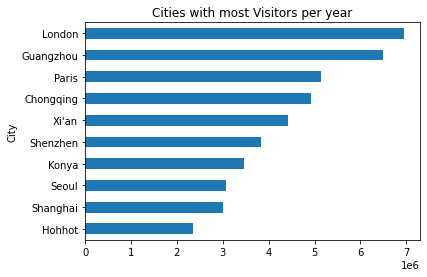

In [ ]:
top_visitors_cities_df[-10:].plot(kind="barh", title='Cities with most Visitors per year')

In [ ]:
population_df = data_df.drop_duplicates(subset="Population",keep="first",ignore_index=True)
population_df.drop(["Name","Year reported"],axis=1,inplace=True)
population_df = population_df.sort_values(by=["Population"],axis=0,ignore_index=True)
population_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,City,Visitors per year,Population,Population Reported Year
0,Vatican City,1300000,825,2019
1,Florence,659000,382258,2017
2,"Washington, D.C.",267000,692683,2019
3,Amsterdam,517000,821752,2015
4,Edinburgh,444437,901455,2021
5,Paris,642416,2161000,2019
6,Taipei,643000,2646000,2019
7,Taichung,2263000,2817000,2020
8,Hohhot,2361000,2867000,2012
9,Madrid,852161,3223000,2018


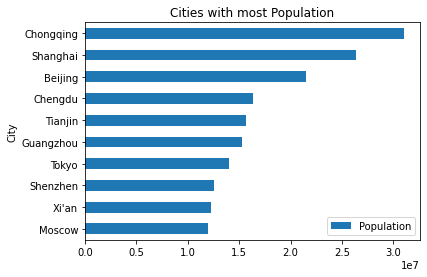

In [ ]:
population_df[-10:].plot(kind="barh",x="City",y="Population", title="Cities with most Population")

In [ ]:
merged_df = population_df.merge(top_visitors_cities_df, how='inner', on='City')
merged_df


,City,Visitors per year_x,Population,Population Reported Year,Visitors per year_y
0,Vatican City,1300000,825,2019,1300000
1,Florence,659000,382258,2017,659000
2,"Washington, D.C.",267000,692683,2019,2249000
3,Amsterdam,517000,821752,2015,517000
4,Edinburgh,444437,901455,2021,444437
5,Paris,642416,2161000,2019,5139416
6,Taipei,643000,2646000,2019,1725000
7,Taichung,2263000,2817000,2020,2263000
8,Hohhot,2361000,2867000,2012,2361000
9,Madrid,852161,3223000,2018,2100161


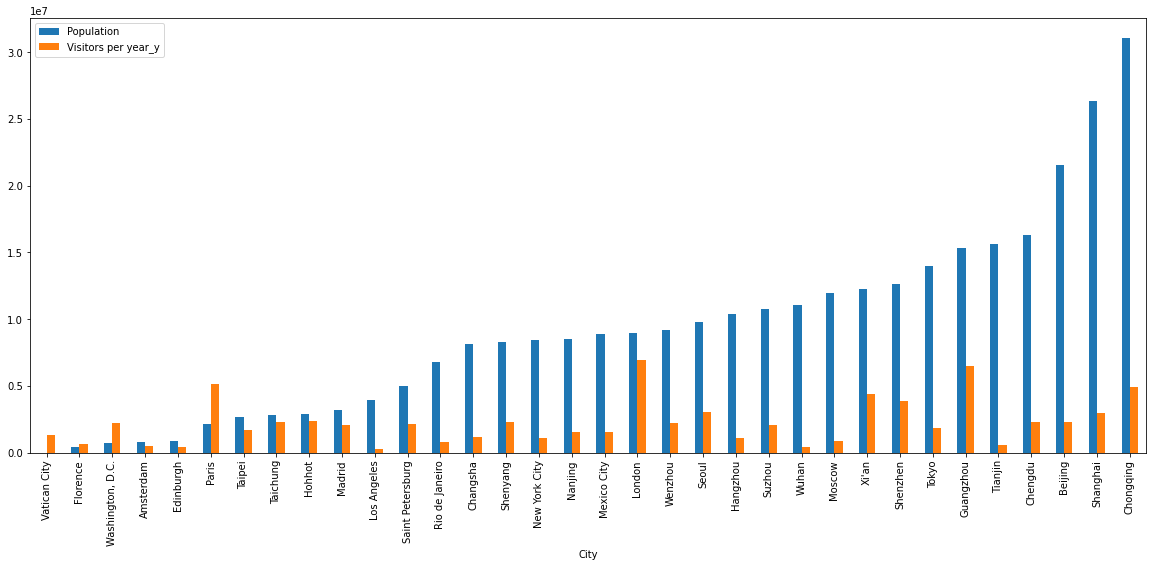

In [ ]:
merged_df.plot(x="City",y=["Population","Visitors per year_y"], kind="bar",figsize=(20,8))
plt.show()

In [ ]:
# assign X and Y
x = data_df['Population'].values  # independent variable
y = data_df['Visitors per year'].values  # dependent variable

In [ ]:
# Model initialization
regression_model = LinearRegression()
# Expected 2D array, so converting 1D array to 2D:
x = x.reshape(-1, 1)


In [ ]:
# Fit the data(train the model)
regression_model.fit(x, y)
# Predict
y_predicted = regression_model.predict(x)

In [ ]:
# model evaluation
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)

In [ ]:
 # printing values
print('Slope:', regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [0.02886426]
Intercept: 1032561.5737541997
Root mean squared error:  794229412008.0438
R2 score:  0.05887245157236909


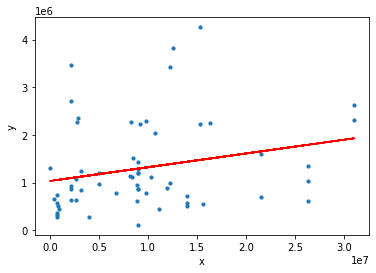

In [ ]:
# plotting values

# data points
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')

# predicted values
plt.plot(x, y_predicted, color='r')
plt.show()